# Generate Training Set for Model
In this notebook, we generate a sample training set for a machine learning model. This involves selecting an appropriate subset of our available data, and generating the features that serve as an input to the machine learning model.

In [1]:
%matplotlib inline
import sys
from glob import glob
sys.path = glob('/projects/CSC249ADCD01/packages/*') + sys.path
from matplotlib import pyplot as plt
import os
import pandas as pd
import numpy as np
import pickle as pkl
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import LeavePGroupsOut
from stopping_power_ml.io import get_charge_density_interpolator
from stopping_power_ml.features import LocalChargeDensity, IonIonForce, ProjectedAGNIFingerprints
from scipy import stats
from tqdm import tqdm_notebook as tqdm
from matminer.featurizers.site import AGNIFingerprints
import stopping_power_ml

Configure Parsl

In [2]:
import parsl
from parsl import *
workers = IPyParallelExecutor()
dfk = DataFlowKernel(executors=[workers])

## Load in Dataset
Load in the pickled dataset from `parse-qbox-data`

In [3]:
data = pkl.load(open('data.pkl', 'rb'))
print('Loaded %d entries'%len(data))

Loaded 50069 entries


## Extract a Single Velocity
Get data from a single velocity

In [4]:
data = data[data['file'].str.contains('Dv1.0')]
print('New dataset contains %d entries'%len(data))

New dataset contains 9800 entries


## Remove the Initial Transient
The first few timesteps are before the projectile has reached equilibrium

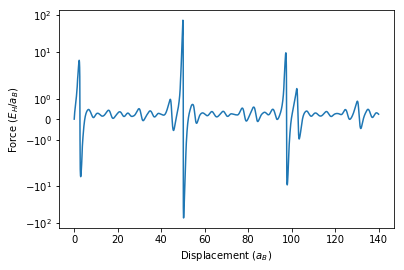

In [5]:
fig, ax = plt.subplots()

ax.plot(data['displacement'], data['force'])

ax.set_yscale('symlog')

ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force ($E_H / a_B$)')

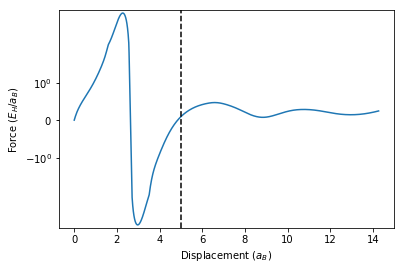

In [6]:
fig, ax = plt.subplots()

ax.plot(data['displacement'][:1000], data['force'][:1000])

ax.set_ylim(ax.get_ylim())

ax.plot([5,]*2, ax.get_ylim(), 'k--')

ax.set_yscale('symlog')

ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force ($E_H / a_B$)')

Remote the transient (greater than 5 should be good)

In [7]:
data.query('displacement >= 5', inplace=True)

## Compute the Representation
We use three kinds of features as input to our machine learning model:

1. *Local Charge Density*: The local electron density at the projectile's current position and several positions in the future and past.
1. *Local Environemnt*: Descriptions of the atom environment around the projectile using the AGNI fingerprints developed by [Botu *et al*](http://pubs.acs.org/doi/10.1021/acs.jpcc.6b10908)
1. *Ion-Ion Repulsion*: The Coulombic repulsion force between the Al atoms and the projectile

### Local Charge Density Features
These features are based on the ground-state electronic structure of Al, as computed using DFT.

In [8]:
charge, cell = get_charge_density_interpolator(os.path.join('datasets', '256_Al', 'Al_semi_core_gs.cube'))

In [9]:
charge_features = LocalChargeDensity(charge, np.linspace(1, -5, 7))

Compute the features. First, we define a parallel function with Parsl

In [10]:
def compute_features(featurizer, data, chunks=96):
    """Compute the features for each entry in the dataframe.
    
    :param featurizer: tool used to compute the features
    :param data: pd.DataFrame, data to be featurized
    :param threads_per_worker: int, number of threads to run on each Parsl worker
    :param chunks: int, number of pieces to evaluate in parallel"""
    
    @App('python', dfk)
    def compute_features(chunk):
        return featurizer.featurize_dataframe(chunk, 'atoms')

    chunks = [compute_features(chunk) for chunk in np.array_split(data, chunks)]
    return pd.concat([c.result() for c in tqdm(chunks, desc='Running')])

In [11]:
%%time
data = compute_features(charge_features, data) 

A Jupyter Widget


Wall time: 45 s


Plot charge as a function of time

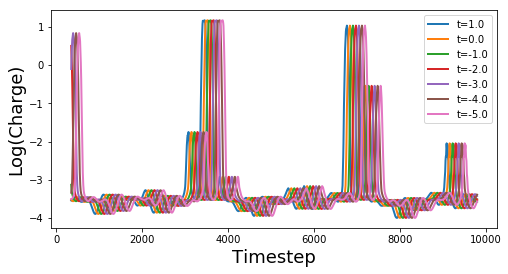

In [12]:
fig, ax = plt.subplots()

for col in charge_features.feature_labels():
    time = col.split(" ")[-1]
    ax.plot(data['timestep'], data[col], label=time, lw=2)

ax.legend()
    
ax.set_xlabel('Timestep', fontsize=18)
ax.set_ylabel('Log(Charge)', fontsize=18)
fig.set_size_inches(8, 4)

## Compute AGNI Fingerprints
Use these to describe the local enviroment around a particle

In [13]:
agni_features = ProjectedAGNIFingerprints(etas=np.logspace(np.log10(0.8), np.log10(16), 8).tolist())

In [14]:
%%time
#data = agni_features.featurize_dataframe(data, 'atoms')
data = compute_features(agni_features, data) # Turned off while writing this notebook

A Jupyter Widget


Wall time: 1min 2s


Plot them as a function of time

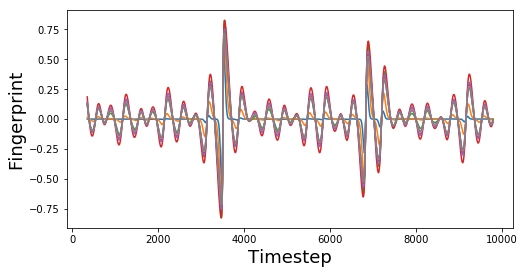

In [15]:
fig, ax = plt.subplots()

for l in agni_features.feature_labels():
    ax.plot(data['timestep'], data[l], label=l)
    
ax.set_ylabel('Fingerprint', fontsize=18)
ax.set_xlabel('Timestep', fontsize=18)
fig.set_size_inches(8, 4)

## Compute Ion-Ion Interaction Forces
Get the repulsion force due to the ion-ion repulsion from the surrounding Al nuclei. Specifically, we compute the force acting on the particle in the direction of travel using the [Ewald summation method](https://en.wikipedia.org/wiki/Ewald_summation).

In [16]:
ewald_features = IonIonForce(acc=2)

In [17]:
%%time
data = compute_features(ewald_features, data) 

A Jupyter Widget


Wall time: 45min 15s


### Plot Force over Time
We want to make sure these forces are smooth

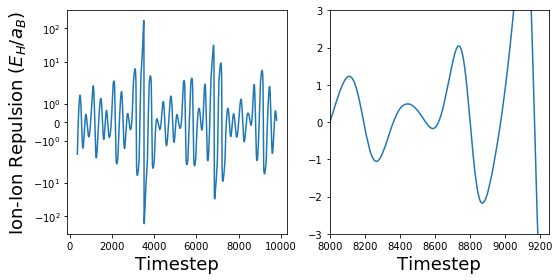

In [18]:
fig, ax = plt.subplots(1, 2, sharey=False)

for a in ax:
    a.plot(data['timestep'], data['ion-ion repulsion'])
    a.set_xlabel('Timestep', fontsize=18)
    
ax[0].set_ylabel('Ion-Ion Repulsion ($E_H / a_B$)', fontsize=18)
ax[0].set_yscale('symlog')

ax[1].set_xlim(8000, 9250)
ax[1].set_ylim(-3, 3)

fig.set_size_inches(8, 4)
fig.tight_layout()

*Finding*: They indeed are smooth. Additionally, we note that the repulsion force varies more quickly than the observed stopping force, which shows the effects of electrons in this system reacting to movements of the projectile.

### Plot Ion-Ion Repulsion Force vs Stopping Force

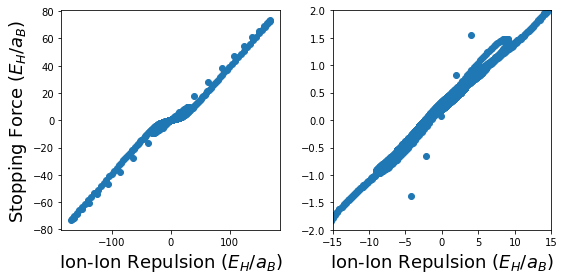

In [19]:
fig, ax = plt.subplots(1, 2)

for a in ax:
    a.scatter(data['ion-ion repulsion'], data['force'])
    a.set_xlabel('Ion-Ion Repulsion ($E_H / a_B$)', fontsize=18)

ax[1].set_xlim(-15, 15)
ax[1].set_ylim(-2, 2)
    
ax[0].set_ylabel('Stopping Force ($E_H / a_B$)', fontsize=18)
fig.set_size_inches(8, 4)
fig.tight_layout()

There are a few things to notice about the ion-ion repulsion force:
- It mostly linearly-correlated with stopping force, which suggests that ion-ion repulsion is an important factor in the observed stopping force
- There is some hysteresis, which shows that ion stopping force is certainly not the only factor.

## Save everything to disk
Except `Atoms` objects. Also save the featurizers

In [20]:
data.drop('atoms', axis='columns').to_csv('training_set.csv', index=False)
data.to_pickle('training_set.pkl')

In [21]:
pkl.dump([charge_features, agni_features, ewald_features], open('featurizers.pkl', 'wb'))

In [22]:
dfk.cleanup()